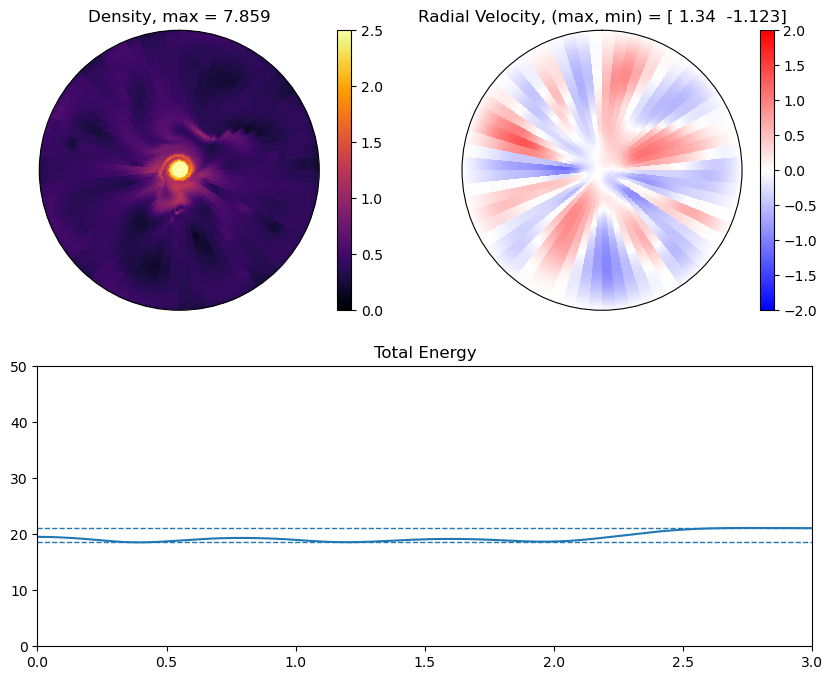

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
import imageio
import io

def getConserved(rho, vr, omega, P, gamma, r):
    momr = rho * vr
    momΘ = rho * r * omega
    E = P / (gamma - 1) + 0.5 * (momr**2 + momΘ**2) / rho
    return np.stack([rho, momr, momΘ, E], axis = 0)
def getPrimitive(U, gamma, r):
    rho, momr, momΘ, E = U
    vr = momr / rho
    omega = momΘ / r / rho
    P = (E - 0.5 * (momr**2 + momΘ**2) / rho) * (gamma - 1)
    return rho, vr, omega, P
def addGhostCells(U, r, Θ, num_ghost):
    # add radial padding; no need for angular due to periodicity of Θ
    U = np.pad(U, pad_width = ((0, 0), (num_ghost, num_ghost), (0, 0)), mode = 'edge')
    r = np.pad(r, pad_width = ((num_ghost, num_ghost), (0, 0)), mode = 'edge')
    Θ = np.pad(Θ, pad_width = ((num_ghost, num_ghost), (0, 0)), mode = 'edge')
    return U, r, Θ
def setGhostCells(U, num_ghost, bc_type = 'reflective'):
    if bc_type == 'outflow':
        for i in range(num_ghost):
            U[:, i, :] = U[:, num_ghost, :]
            U[:, -1 - i, :] = U[:, -1 - num_ghost, :]
        

    elif bc_type == 'reflective':
        for i in range(num_ghost):
            # copy cells
            U[:, i, :] = U[:, num_ghost, :]
            U[:, -1 - i, :] = U[:, -1 - num_ghost, :]
            # flip radial momentum
            U[1, i, :] *= -1
            U[1, -1 - i, :] *= -1

    return U
def rusanov_flux(U_L, U_R, gamma, direction = 'r'):
    rho_L, momr_L, momΘ_L, E_L = U_L
    rho_R, momr_R, momΘ_R, E_R = U_R

    P_L = (E_L - 0.5 * (momr_L**2 + momΘ_L**2) / rho_L) * (gamma - 1)
    P_R = (E_R - 0.5 * (momr_R**2 + momΘ_R**2) / rho_R) * (gamma - 1)

    C_L = np.sqrt(gamma * P_L / rho_L)
    C_R = np.sqrt(gamma * P_R / rho_R)

    if direction == 'r':
        flux_L = np.array([momr_L,
                            momr_L**2 / rho_L + P_L,
                            momr_L * momΘ_L / rho_L,
                            momr_L / rho_L * (E_L + P_L)])
        flux_R = np.array([momr_R,
                            momr_R**2 / rho_R + P_R,
                            momr_R * momΘ_R / rho_R,
                            momr_R / rho_R * (E_R + P_R)])
        
        a = np.maximum(np.abs(momr_L / rho_L) + C_L,
                        np.abs(momr_R / rho_R) + C_R)
    elif direction == 'Θ':
        flux_L = np.array([momΘ_L,
                           momΘ_L * momr_L / rho_L,
                           momΘ_L**2 / rho_L + P_L,
                           momΘ_L / rho_L * (E_L + P_L)])
        flux_R = np.array([momΘ_R,
                           momΘ_R * momr_R / rho_R,
                           momΘ_R**2 / rho_R + P_R,
                           momΘ_R / rho_R * (E_R + P_R)])
        
        a = np.maximum(np.abs(momΘ_L / rho_L) + C_L,
                        np.abs(momΘ_R / rho_R) + C_R)
        
    flux = 0.5 * (flux_L + flux_R) - 0.5 * a * (U_R - U_L)
    return flux
def hllc_flux(U_L, U_R, gamma, direction = 'r'):
    rho_L, momr_L, momΘ_L, E_L = U_L
    rho_R, momr_R, momΘ_R, E_R = U_R

    P_L = (E_L - 0.5 * (momr_L**2 + momΘ_L**2) / rho_L) * (gamma - 1)
    P_R = (E_R - 0.5 * (momr_R**2 + momΘ_R**2) / rho_R) * (gamma - 1)

    C_L = np.sqrt(gamma * P_L / rho_L)
    C_R = np.sqrt(gamma * P_R / rho_R)

    if direction == 'r':
        flux_L = np.array([momr_L,
                            momr_L**2 / rho_L + P_L,
                            momr_L * momΘ_L / rho_L,
                            momr_L / rho_L * (E_L + P_L)])
        flux_R = np.array([momr_R,
                            momr_R**2 / rho_R + P_R,
                            momr_R * momΘ_R / rho_R,
                            momr_R / rho_R * (E_R + P_R)])
        
        S_L = np.minimum(momr_L / rho_L - C_L, momr_R / rho_R - C_R)
        S_R = np.maximum(momr_L / rho_L + C_L, momr_R / rho_R + C_R)
        num = P_R - P_L + momr_L * (S_L - momr_L / rho_L) - momr_R * (S_R - momr_R / rho_R)
        den = (rho_L * S_L - momr_L) - (rho_R * S_R - momr_R)
        S = num/den
        rho_star_L = (rho_L * S_L - momr_L) / (S_L - S)
        rho_star_R = (rho_R * S_R - momr_R) / (S_R - S)
        U_star_L = np.array([rho_star_L,
                            rho_star_L * S,
                            rho_star_L * momΘ_L / rho_L,
                            rho_star_L * (E_L / rho_L + (S - momr_L / rho_L) * (S + P_L / (rho_L * S_L - momr_L)))])
        U_star_R = np.array([rho_star_R,
                            rho_star_R * S,
                            rho_star_R * momΘ_R / rho_R,
                            rho_star_R * (E_R / rho_R + (S - momr_R / rho_R) * (S + P_R / (rho_R * S_R - momr_R)))])
    elif direction == 'Θ':
        flux_L = np.array([momΘ_L,
                           momΘ_L * momr_L / rho_L,
                           momΘ_L**2 / rho_L + P_L,
                           momΘ_L / rho_L * (E_L + P_L)])
        flux_R = np.array([momΘ_R,
                           momΘ_R * momr_R / rho_R,
                           momΘ_R**2 / rho_R + P_R,
                           momΘ_R / rho_R * (E_R + P_R)])
        
        S_L = np.minimum(momΘ_L / rho_L - C_L, momΘ_R / rho_R - C_R)
        S_R = np.maximum(momΘ_L / rho_L + C_L, momΘ_R / rho_R + C_R)
        num = P_R - P_L + momΘ_L * (S_L - momΘ_L / rho_L) - momΘ_R * (S_R - momΘ_R / rho_R)
        den = (rho_L * S_L - momΘ_L) - (rho_R * S_R - momΘ_R)
        S = num / den
        rho_star_L = (rho_L * S_L - momΘ_L) / (S_L - S)
        rho_star_R = (rho_R * S_R - momΘ_R) / (S_R - S)
        U_star_L = np.array([rho_star_L,
                             rho_star_L * momr_L / rho_L,
                             rho_star_L * S,
                             rho_star_L * (E_L / rho_L + (S - momΘ_L / rho_L) * (S + P_L / (rho_L * S_L - momΘ_L)))])
        U_star_R = np.array([rho_star_R,
                             rho_star_R * momr_R / rho_R,
                             rho_star_R * S,
                             rho_star_R * (E_R / rho_R + (S - momΘ_R / rho_R) * (S + P_R / (rho_R * S_R - momΘ_R)))])

    flux = flux_R
    flux = np.where(S_L > 0, flux_L, flux)
    flux = np.where((S_L <= 0) & (0 <= S), flux_L + S_L * (U_star_L - U_L), flux)
    flux = np.where((S <= 0) & (0 <= S_R), flux_R + S_R * (U_star_R - U_R), flux)

    return flux
def hlle_flux(U_L, U_R, gamma, direction = 'r'):
    rho_L, momr_L, momΘ_L, E_L = U_L
    rho_R, momr_R, momΘ_R, E_R = U_R

    P_L = (E_L - 0.5 * (momr_L**2 + momΘ_L**2) / rho_L) * (gamma - 1)
    P_R = (E_R - 0.5 * (momr_R**2 + momΘ_R**2) / rho_R) * (gamma - 1)

    C_L = np.sqrt(gamma * P_L / rho_L)
    C_R = np.sqrt(gamma * P_R / rho_R)

    if direction == 'r':
        flux_L = np.array([momr_L,
                            momr_L**2 / rho_L + P_L,
                            momr_L * momΘ_L / rho_L,
                            momr_L / rho_L * (E_L + P_L)])
        flux_R = np.array([momr_R,
                            momr_R**2 / rho_R + P_R,
                            momr_R * momΘ_R / rho_R,
                            momr_R / rho_R * (E_R + P_R)])
        
        S_L = np.minimum(momr_L / rho_L - C_L, momr_R / rho_R - C_R)
        S_R = np.maximum(momr_L / rho_L + C_L, momr_R / rho_R + C_R)
    elif direction == 'Θ':
        flux_L = np.array([momΘ_L,
                           momΘ_L * momr_L / rho_L,
                           momΘ_L**2 / rho_L + P_L,
                           momΘ_L / rho_L * (E_L + P_L)])
        flux_R = np.array([momΘ_R,
                           momΘ_R * momr_R / rho_R,
                           momΘ_R**2 / rho_R + P_R,
                           momΘ_R / rho_R * (E_R + P_R)])
        
        S_L = np.minimum(momΘ_L / rho_L - C_L, momΘ_R / rho_R - C_R)
        S_R = np.maximum(momΘ_L / rho_L + C_L, momΘ_R / rho_R + C_R)

    flux = (S_R * flux_L - S_L * flux_R + S_L * S_R * (U_R - U_L)) / (S_R - S_L)
    flux = np.where(S_L > 0, flux_L, flux)
    flux = np.where(S_R < 0, flux_R, flux)

    return flux
def solve_poisson_polar(rho, r, G, num_ghost):
    Nr, Nθ = rho.shape
    Nr -= 2*num_ghost  # strip ghost cells
    dr = r[num_ghost + 1, 0] - r[num_ghost, 0]

    # Physical domain
    rho_phys = rho[num_ghost:-num_ghost-1, :]
    r_phys = r[num_ghost: -num_ghost-1,:]

    # Compute gr via cumulative trapezoidal integration
    gr = np.zeros((Nr + 2*num_ghost, Nθ))

    integral = np.cumsum(rho_phys * r_phys, axis = 0) * dr
    gr[num_ghost: -num_ghost-1,:] = -4 * np.pi * G * integral / r_phys

    # Assume gΘ = 0 (axisymmetric)
    gΘ = np.zeros_like(gr)

    # Enforce BCs on ghost cells
    for i in range(num_ghost):
        # Reflective BC at r = 0 (mirror symmetry)
        gr[i, :] = -gr[num_ghost, :]

        # Neumann BC at outer edge (zero radial derivative)
        gr[-(i+1), :] = gr[-num_ghost - 1, :]

    return gr, gΘ
def addSourceTerm(U, G, r, dt, num_ghost):
    rho, momr, momΘ, E = U
    geometric = np.array([np.zeros_like(rho),
                          momΘ**2 / rho / r,
                          -momr * momΘ / rho / r,
                          np.zeros_like(E)])
    
    
    gr, gΘ = solve_poisson_polar(rho, r, G, num_ghost)
    self_gravity = np.array([np.zeros_like(rho),
                             -rho * gr,
                             -rho * gΘ / r,
                             -momr * gr + momΘ * gΘ / r])
    
    U += dt * (geometric + self_gravity)
    return U
def compute_hydrostatic_pressure(rho, r, dr, dΘ, G):
    dP_dr = -G * rho**2 * dr * dΘ / r
    # integration over r
    P = np.cumsum(dP_dr, axis = 0) * dr
    return P
def main(U = None, filename = None, return_state = False):
    Nr =                    128              # Number of radial divisions
    NΘ =                    64              # Number of angular divisions
    gamma =                 1.4             # Adiabatic constant
    G =                     1               # Gravitational constant
    CFL =                   0.4             # Courant number
    t_end =                 3.0
    t_flux_switch =         0.16            # time to switch from HLLE to HLLC
    t_out =                 0.01            # t value to output frame
    plotRealTime =          True
    bc_type =               'reflective'
    num_ghost =             1              # Number of ghost cells
    E_max =                 50              # Upper bound for total energy plot
    rmax =                  1.0             # radius of simulation
    Θmax =                  2 * np.pi       # angle of simulation
    eps =                   1e-2            # minimum radius to avoid singularity

    P0 =                    2.5              # starting pressure
    rho_vac =               1e-8            # nonzero starting density to avoid division by zero

    rho1, r1, w1 = 2.0, 0.3, 0.1            # densities, radii, and widths of interfaces
    rho2, r2, w2 = 1.0, 0.6, 0.1            #       between each layer of star's core

    noise_strength = 0.0025                 # random noise (from -0.5 to +0.5) applied at interface
    cosine_strength = 0.0025                # controlled noise (from 0.0 to 1.0) applied at interface
    mode_number = 8                         # freq. of controlled noise

    def interface_mask(r, r0, w): 
        return (r > r0 - w/2) & (r < r0 + w/2)      # boolean mask for use with np.where


    dr = (rmax - eps) / Nr
    dΘ = Θmax / NΘ
    rlin = np.linspace(eps + dr / 2, rmax - dr / 2, Nr)     # center-based approach
    Θlin = np.linspace(dΘ / 2, Θmax - dΘ / 2, NΘ)

    Θ, r = np.meshgrid(Θlin, rlin)                          # radial axis = 0, angular axis = 1 <--> f(r, Θ) = f_ij

    rho = (np.where(r <= r1, rho1, rho_vac) + 
           np.where((r > r1) & (r <= r2), rho2 - rho_vac, 0.0))
    P = P0 + compute_hydrostatic_pressure(rho, r, dr, dΘ, G)
    vr = np.where(interface_mask(r, r1, w1), noise_strength*(np.random.rand(*Θ.shape) - 0.5) + cosine_strength*(1 - np.cos(mode_number * Θ)), 0)
    omega = np.where(interface_mask(r, r1, w1), noise_strength*(np.random.rand(*Θ.shape) - 0.5), 0)

    # allow loading a saved state U
    if U is None:
        U = getConserved(rho, vr, omega, P, gamma, r)
    
    U, r, Θ = addGhostCells(U, r, Θ, num_ghost)

    # time-integration while loop
    frames = []
    Es = []
    outputCount = 1
    t = 0.0
    while t < t_end:
        # restore BCs and redeclare variables every timestep
        U = setGhostCells(U, num_ghost, bc_type = bc_type) 
        rho, momr, momΘ, E = U
        rho, vr, omega, P = getPrimitive(U, gamma, r)

        # use CFL condition to determine the necessary timestep
        dt = CFL * np.min(r * dΘ) / np.max(np.sqrt(gamma * P / rho) + np.sqrt((momr**2 + momΘ**2)) / rho)
        
        plotThisTurn = False
        if t + dt > outputCount * t_out:
            dt = outputCount * t_out - t
            plotThisTurn = True

        # kick
        U = addSourceTerm(U, G, r, dt / 2, num_ghost)

        flux_fn = hlle_flux           # hlle in the first few moments to deal with the intial shock
        if t > t_flux_switch:
            flux_fn = hllc_flux          # hllc afterwords to limit diffusion

        # fluxes computed at interfaces between neighboring cells
        F_L = flux_fn(np.roll(U, 1, axis = 1), U, gamma, 'r')       
        F_R = flux_fn(U, np.roll(U, -1, axis = 1), gamma, 'r')
        G_L = flux_fn(np.roll(U, 1, axis = 2), U, gamma, 'Θ')
        G_R = flux_fn(U, np.roll(U, -1, axis = 2), gamma, 'Θ')

        r_fac = r[np.newaxis, :, :] # for broadcasting 2d onto 3d array
        Fdiv = ((r_fac + dr/2) * F_R - (r_fac - dr/2) * F_L) / dr
        Gdiv = (G_R - G_L) / dΘ 

        # drift
        U += -dt * (Fdiv + Gdiv) / r_fac    # Euler's method timestep. Maybe consider Runge-Kutta?
        
        # kick
        U = addSourceTerm(U, G, r, dt / 2, num_ghost)

        t += dt
        print(f"\rdt = {dt:.5e}, t = {t:.5e}", end="", flush=True)
        # realtime plotting of rho, vr, and E_tot
        if (plotRealTime and plotThisTurn) or (t >= t_end):
            clear_output(wait = True)

            fig = plt.figure(figsize = (10, 8))
            
            gs = gridspec.GridSpec(2, 2, height_ratios = [1, 1])
            ax1 = fig.add_subplot(gs[0,0], projection = 'polar')
            ax2 = fig.add_subplot(gs[0, 1], projection = 'polar')
            ax3 = fig.add_subplot(gs[1, :])

            ax1.set_theta_zero_location('N')
            ax1.set_theta_direction(-1)
            pcm1 = ax1.pcolormesh(Θ[num_ghost: -num_ghost - 1,:], r[num_ghost: -num_ghost - 1,:], rho[num_ghost: -num_ghost - 1,:], cmap = 'inferno',shading = 'auto', vmin = 0.0, vmax = 2.5)

            ax1.get_xaxis().set_visible(False)
            ax1.get_yaxis().set_visible(False)
            ax1.set_aspect("equal")
            ax1.set_title(("Density, max = " + str(np.round(np.max(rho[num_ghost: -num_ghost - 1,:]), 3))))
            fig.colorbar(pcm1, ax = ax1)

            ax2.set_theta_zero_location('N')
            ax2.set_theta_direction(-1)
            pcm2 = ax2.pcolormesh(Θ[num_ghost: -num_ghost - 1,:], r[num_ghost: -num_ghost - 1,:], (momr / rho)[num_ghost: -num_ghost - 1,:], cmap = 'bwr',shading = 'auto', vmin = -2.0, vmax = 2.0)

            ax2.get_xaxis().set_visible(False)
            ax2.get_yaxis().set_visible(False)
            ax2.set_aspect("equal")
            ax2.set_title(("Radial Velocity, (max, min) = " + str(np.round((np.max((momr / rho)[num_ghost: -num_ghost - 1,:]), np.min((momr / rho)[num_ghost: -num_ghost - 1,:])),3))))
            fig.colorbar(pcm2, ax = ax2)

            Es.append(np.sum((E * r * dr * dΘ)[num_ghost: -num_ghost,:])) # E represents energy per unit volume
            ts = np.linspace(0, len(Es) * t_out, len(Es))
            
            ax3.set_xlim(0, t_end)
            ax3.set_ylim(0, E_max)
            ax3.set_title("Total Energy")
            ax3.axhline(y = max(Es), linestyle = '--', linewidth=1)
            ax3.axhline(y = min(Es), linestyle = '--', linewidth=1)
            ax3.plot(ts, Es)

            plt.pause(0.001)
            outputCount += 1

            buf = io.BytesIO()
            fig.savefig(buf, format='png')
            buf.seek(0)
            image = imageio.v3.imread(buf)
            frames.append(image)
            buf.close()
            
    
    if filename is not None:
        imageio.mimsave(filename, frames, fps=10)
    if return_state == True:
        return U

In [ ]:
import glob
import os
 
def concatenate():
  global stringa
  stringa = "ffmpeg -i \"concat:"
  elenco_video = glob.glob("*.mp4")
  elenco_file_temp = []
  for f in elenco_video:
    file = "temp" + str(elenco_video.index(f) + 1) + ".ts"
    os.system("ffmpeg -i " + f + " -c copy -bsf:v h264_mp4toannexb -f mpegts " + file)
    elenco_file_temp.append(file)
  print(elenco_file_temp)
  for f in elenco_file_temp:
    stringa += f
    if elenco_file_temp.index(f) != len(elenco_file_temp)-1:
      stringa += "|"
    else:
      stringa += "\" -c copy  -bsf:a aac_adtstoasc output.mp4"
  print(stringa)
  os.system(stringa)

In [ ]:
concatenate()

['temp1.ts', 'temp2.ts']
ffmpeg -i "concat:temp1.ts|temp2.ts" -c copy  -bsf:a aac_adtstoasc output.mp4


In [ ]:
[0,1,2,3,4,5,6][0:-1]

[0, 1, 2, 3, 4, 5]